In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/tenx/Fraud_Detection_For_E_commerce_and_Bank_Transactions/notebooks

/content/drive/MyDrive/tenx/Fraud_Detection_For_E_commerce_and_Bank_Transactions/notebooks


**Data Preprocessing**

**Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from scipy.stats import zscore
import warnings

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
def missing_values_proportions(df):
  missing_values = df.isnull().sum()
  missing_values = missing_values[missing_values > 0]

  missing_proportions = 100 * (missing_values / len(df))
  missing_proportions = missing_proportions.round(2)

  return pd.DataFrame({"Missing Values": missing_values, "proportion (%)": missing_proportions})



In [ ]:
def handle_outliers(df, columns, plot_box=False, replace_with="boundaries"):
  """Detect and handle outliers in specified columns of a DataFrame."""
  for col in columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    if replace_with == "boundaries":
      df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    elif replace_with == "mean":
      mean = df[col].mean()
      df[col] = np.where((df[col]<lower_bound) | (df[col]>upper_bound),mean,df[col])
    else:
      raise ValueError("replace_with must be either 'baoundaries' or 'mean'.")
    if plot_box:
      plt.figure(figsize=(6,0.3))
      sns.boxplot(x=df[col])
      plt.title(f"Box plot for {col} replace with {replace_with}")
      plt.show()
  return df


In [ ]:
sns.set_style("whitegrid")
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)

**Data Loading**

In [ ]:
CREDIT_DATA_PATH = "../Data/raw/creditcard.csv"
FRAUD_DATA_PATH = "../Data/raw/Fraud_Data.csv"
IP_DATA_PATH = "../Data/raw/IpAddress_to_Country.csv"

In [ ]:
credit_df = pd.read_csv(CREDIT_DATA_PATH)
credit_df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
fraud_df = pd.read_csv(FRAUD_DATA_PATH)
fraud_df.head(5)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [ ]:
Ip_df = pd.read_csv(IP_DATA_PATH)
Ip_df.head(5)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


**Data Inspection**

In [ ]:
print(f"Credit Card Data Shape: {credit_df.shape}")
print(f"Fraud Data Shape: {fraud_df.shape}")
print(f"Ip Data Shape: {Ip_df.shape}")

Credit Card Data Shape: (284807, 31)
Fraud Data Shape: (151112, 11)
Ip Data Shape: (138846, 3)


Inspect Data General Info

In [ ]:
print(f"Credit Card Data Info:\n")
credit_df.info()

Credit Card Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null 

In [ ]:
print(f"Fraud Data Info:\n ")
fraud_df.info()

Fraud Data Info:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [ ]:
print(f"Ip Data Info:\n")
Ip_df.info()

Ip Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


Inspect Data Uniqueness

In [ ]:
print("Number of unique values in each column of Credit dataset:\n")
print("_"*80,f"{'Column Name':>45} | Unique Values","_"*80,sep="\n")
for col in credit_df.columns:
  print(f"{col:>45} | {credit_df[col].nunique()}")
print("_"*80)

Number of unique values in each column of Credit dataset:

________________________________________________________________________________
                                  Column Name | Unique Values
________________________________________________________________________________
                                         Time | 124592
                                           V1 | 275663
                                           V2 | 275663
                                           V3 | 275663
                                           V4 | 275663
                                           V5 | 275663
                                           V6 | 275663
                                           V7 | 275663
                                           V8 | 275663
                                           V9 | 275663
                                          V10 | 275663
                                          V11 | 275663
                                          V12 | 275663
  

In [ ]:
print("Number of Unique Values in Each Column of Fraud Dataset:\n")
print("_"*80,f"{'Column Name':>45} | Unique_Values","_"*80, sep="\n")

for col in fraud_df.columns:
  print(f"{col:>45} | {fraud_df[col].nunique()}")
print("_"*80)

Number of Unique Values in Each Column of Fraud Dataset:

________________________________________________________________________________
                                  Column Name | Unique_Values
________________________________________________________________________________
                                      user_id | 151112
                                  signup_time | 151112
                                purchase_time | 150679
                               purchase_value | 122
                                    device_id | 137956
                                       source | 3
                                      browser | 5
                                          sex | 2
                                          age | 58
                                   ip_address | 143512
                                        class | 2
________________________________________________________________________________


In [ ]:
print("Number of Unique Values in Each Column of IP Address Dataset")
print("_"*80, f"{'Column Name':>45} | Unique_Values","_"*80, sep="\n")

for col in Ip_df.columns:
  print(f"{col:>45} | {Ip_df[col].nunique()}")
print("_"*80)

Number of Unique Values in Each Column of IP Address Dataset
________________________________________________________________________________
                                  Column Name | Unique_Values
________________________________________________________________________________
                       lower_bound_ip_address | 138846
                       upper_bound_ip_address | 138846
                                      country | 235
________________________________________________________________________________


**Inspect Data Missingness**

In [ ]:
print("Missing values and their proportions (%) in Credit DataFrame:")
missing_values_proportions(credit_df)

Missing values and their proportions (%) in Credit DataFrame:


,Missing Values,proportion (%)


In [ ]:
print("Missing values and their proportions (%) in Fraud DataFrame:")
missing_values_proportions(fraud_df)

Missing values and their proportions (%) in Fraud DataFrame:


,Missing Values,proportion (%)


In [ ]:
print("Missing values and their proportions (%) in Ip Adress DataFrame:")
missing_values_proportions(Ip_df)

Missing values and their proportions (%) in Ip Adress DataFrame:


,Missing Values,proportion (%)


there are no missing values in the dataframes

**Inspect Data Duplication**

In [ ]:
duplicated_rows = credit_df[credit_df.duplicated()]
print(f"Number of duplicated rows in Credit DataFrame: {duplicated_rows.shape[0]}")

Number of duplicated rows in Credit DataFrame: 1081


In [ ]:
duplicated_rows = fraud_df[fraud_df.duplicated()]
print(f"Number of duplicated rows in Fraud DataFrame: {duplicated_rows.shape[0]}")

Number of duplicated rows in Fraud DataFrame: 0


In [ ]:
duplicated_rows = Ip_df[Ip_df.duplicated()]
print(f"Number of duplicated rows in Ip Address DataFrame: {duplicated_rows.shape[0]}")

Number of duplicated rows in Ip Address DataFrame: 0


**Data Preprocessing**

Handling Duplicates

In [ ]:
credit_df = credit_df.drop_duplicates()
print(f"Number of duplicated rows in Credit DataFrame: {credit_df.duplicated().sum()}")

Number of duplicated rows in Credit DataFrame: 0


**Data Type Conversion**

In [ ]:
credit_df.dtypes

,0
Time,float64
V1,float64
V2,float64
V3,float64
V4,float64
V5,float64
V6,float64
V7,float64
V8,float64
V9,float64


In [ ]:
fraud_df.dtypes

,0
user_id,int64
signup_time,object
purchase_time,object
purchase_value,int64
device_id,object
source,object
browser,object
sex,object
age,int64
ip_address,float64


In [ ]:
Ip_df.dtypes

,0
lower_bound_ip_address,float64
upper_bound_ip_address,int64
country,object


In [ ]:
fraud_df["ip_address"] = fraud_df["ip_address"].astype(int)
fraud_df.dtypes

,0
user_id,int64
signup_time,object
purchase_time,object
purchase_value,int64
device_id,object
source,object
browser,object
sex,object
age,int64
ip_address,int64


**Handling Outliers**

Outlier Handling for credit_df

In [ ]:
numerical_columns = [
    col for col in credit_df.select_dtypes(include=[np.number]).columns
    if col not in ["Class", "Amount"]
]

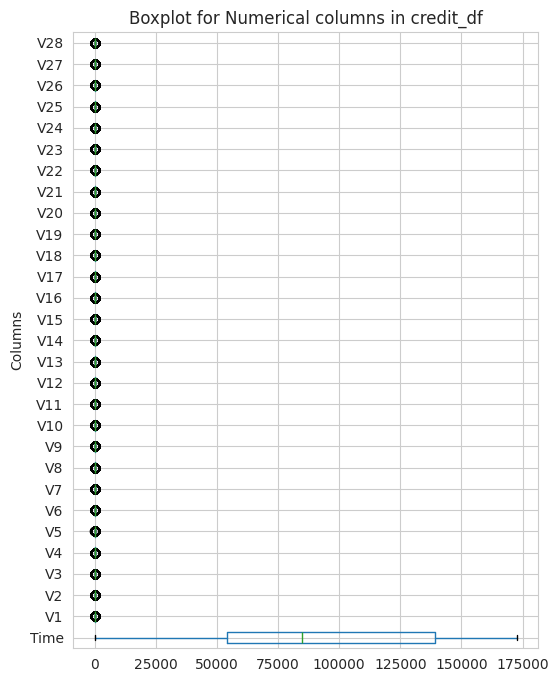

In [ ]:
# Detect Outliers Using Boxplots for credit_df
plt.figure(figsize = (6,8))
credit_df.boxplot(column = numerical_columns, vert=False,)
plt.title("Boxplot for Numerical columns in credit_df")
plt.ylabel("Columns")
plt.show()


In [ ]:
# Replace outliers with boundaries for all numerical columns
credit_df = handle_outliers(
    credit_df, numerical_columns, plot_box=False, replace_with="mean"
)

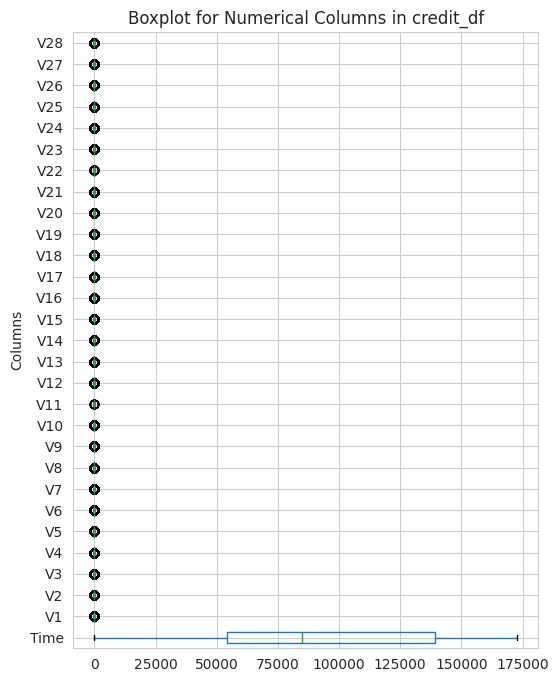

In [ ]:
# Detect Outliers Using Boxplots for credit_df
plt.figure(figsize=(6, 8))
credit_df.boxplot(
    column=numerical_columns,
    vert=False,
)
plt.title("Boxplot for Numerical Columns in credit_df")
plt.ylabel("Columns")
plt.show()

In [ ]:
# Check for remaining outliers using Z-Score
print("\nColumns with Potential Outliers After Z-Score Analysis:\n")
for col in numerical_columns:
    z_scores = zscore(credit_df[col])
    outliers = (np.abs(z_scores) > 3).sum()
    print(f"{col:>45}: {outliers} potential outliers")


Columns with Potential Outliers After Z-Score Analysis:

                                         Time: 0 potential outliers
                                           V1: 478 potential outliers
                                           V2: 12 potential outliers
                                           V3: 0 potential outliers
                                           V4: 0 potential outliers
                                           V5: 0 potential outliers
                                           V6: 805 potential outliers
                                           V7: 0 potential outliers
                                           V8: 0 potential outliers
                                           V9: 0 potential outliers
                                          V10: 0 potential outliers
                                          V11: 30 potential outliers
                                          V12: 0 potential outliers
                                          V13: 0 pot

Outlier Handling for fraud_df

In [ ]:
numerical_columns = [
    col
    for col in fraud_df.select_dtypes(include=[np.number]).columns
    if col not in ["ip_address", "class"]
]

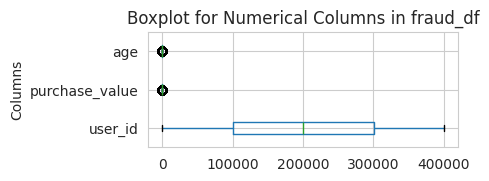

In [ ]:
# Detect Outliers Using Boxplots for fraud_df
plt.figure(figsize=(4, 1.5))

fraud_df.boxplot(
    column=numerical_columns,
    vert=False,
)
plt.title("Boxplot for Numerical Columns in fraud_df")
plt.ylabel("Columns")
plt.show()

In [ ]:
# Replace outliers with boundaries for all numerical columns
fraud_df = handle_outliers(
    fraud_df, numerical_columns, plot_box=False, replace_with="mean"
)

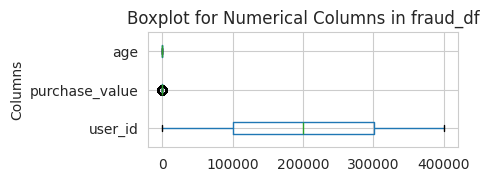

In [ ]:
# Detect Outliers Using Boxplots for fraud_df
plt.figure(figsize=(4, 1.5))

fraud_df.boxplot(
    column=numerical_columns,
    vert=False,
)
plt.title("Boxplot for Numerical Columns in fraud_df")
plt.ylabel("Columns")
plt.show()

In [ ]:
# Check for remaining outliers using Z-Score
print("\nColumns with Potential Outliers After Z-Score Analysis:\n")

for col in numerical_columns:
  z_scores = zscore(fraud_df[col])
  outliers =(np.abs(z_scores)>3).sum()
  print(f"{col:>45}: {outliers} potential outliers")


Columns with Potential Outliers After Z-Score Analysis:

                                      user_id: 0 potential outliers
                               purchase_value: 0 potential outliers
                                          age: 0 potential outliers


**IP Address to Country Mapping**

This section assigns a country to each row in fraud_df by matching its ip_address to the corresponding range in ip_df. If an IP falls within a specified range, the country is assigned to the fraud_df dataframe.

In [ ]:
for row in fraud_df.iterrows():
  ip_address = row[1]["ip_address"]
  country = Ip_df[
      (Ip_df["lower_bound_ip_address"]<=ip_address)
      & (Ip_df["upper_bound_ip_address"] >= ip_address)
  ]["country"].values
  if len(country) > 0:
    fraud_df.loc[row[0], "country"] = country[0]



In [ ]:
fraud_df.head(2)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058.0,2015-02-24 22:55:49,2015-04-18 02:47:11,34.0,QVPSPJUOCKZAR,SEO,Chrome,M,39.0,732758368,0,Japan
1,333320.0,2015-06-07 20:39:50,2015-06-08 01:38:54,16.0,EOGFQPIZPYXFZ,Ads,Chrome,F,53.0,350311387,0,United States


In [ ]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  float64
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  float64
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  float64
 9   ip_address      151112 non-null  int64  
 10  class           151112 non-null  int64  
 11  country         129146 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 13.8+ MB


In [ ]:
fraud_df = fraud_df.dropna()
print(fraud_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 129146 entries, 0 to 151110
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         129146 non-null  float64
 1   signup_time     129146 non-null  object 
 2   purchase_time   129146 non-null  object 
 3   purchase_value  129146 non-null  float64
 4   device_id       129146 non-null  object 
 5   source          129146 non-null  object 
 6   browser         129146 non-null  object 
 7   sex             129146 non-null  object 
 8   age             129146 non-null  float64
 9   ip_address      129146 non-null  int64  
 10  class           129146 non-null  int64  
 11  country         129146 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 12.8+ MB
None


In [ ]:
fraud_df.to_csv("../Data/processed/merged_fraud_df.csv")
credit_df.to_csv("../Data/processed/cleaned_credit_df.csv")